In [1]:
import os
import pickle
import keras
import time

import numpy as np
import pandas as pd
import seaborn as sn
import random as rn
import tensorflow as tf
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
########################################
# TF-IDF→MLP
########################################
data=pickle.load(open('/Users/Baron/Document/text_mining/Data/pickle/TF-IDF/Headline/tfidf_headline.pickle', "rb"))
z = data[0]
y = data[1]
x = data[2]
print(len(x[0]))
kf = KFold(n_splits=5, shuffle=True, random_state=0)
# 分類するラベルの数 --- (*1)
nb_classes = 4
# ラベルデータをone-hotベクトルに直す --- (*3)
y = keras.utils.np_utils.to_categorical(y, nb_classes)

# データの次元数
x_size = x[0].shape[0]
y_size = y[0].shape[0]

A_index=[]
B_index=[]
C_index=[]
D_index=[]
E_index=[]
F_index=[]

# 交差検証
for train, test in kf.split(x):
    A=np.empty((0,x_size), int)
    B=np.empty((0,x_size), int)
    C=np.empty((0,y_size), int)
    D=np.empty((0,y_size), int)
    E = []
    F = []
    for i in test:
        A = np.append(A, [x[i]], axis=0)           # x_test
        C = np.append(C, [y[i]], axis=0)           # y_test
        E.append(z[i])                                          # z_test
    A_index.append(A)
    C_index.append(C)
    E_index.append(E)
    for j in train:
        B = np.append(B, [x[j]], axis=0)            # x_train
        D = np.append(D, [y[j]], axis=0)           # y_train
        F.append(z[j])                                         # z_train
    B_index.append(B)
    D_index.append(D)
    F_index.append(F)
    

8742


In [3]:
def MLP_print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (12,8))
    sn.heatmap(df_cmx, annot=True, fmt="d") ### ヒートマップの表示仕様
    plt.title("Confusion Matrix")
    plt.xlabel("predict_classes")
    plt.ylabel("true_classes")
    plt.show()

In [4]:
def MLP(x_test, x_train, y_test, y_train, z_test, z_train, x_size, p):
    # MLPモデル構造を定義 --- (*5)
    MLP_model = Sequential()
    MLP_model.add(Dense(512, activation='relu', input_shape=(x_size,)))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(512, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(512, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(nb_classes, activation='softmax'))

    # モデルをコンパイル --- (*6)
    MLP_model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(),
        metrics=['accuracy'])
    
    t1 = time.time()                 #　開始
    # 学習を実行 --- (*7)
    hist = MLP_model.fit(x_train, y_train,
              batch_size=128, 
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
    t2 = time.time()                #　終了
    
    # 重みデータを保存 --- (*9)
    MLP_model.save_weights('./model/TFIDF_headline_model_'+str(p)+'.hdf5')
    
    #  混同行列
    predict_classes = MLP_model.predict_classes(x_test[1:10000]) ### 予測したラベルを取得
    true_classes = np.argmax(y_test[1:10000], 1) ### 実際のラベルを取得
    
    # 評価する ---(*8)
    score = MLP_model.evaluate(x_test, y_test, verbose=1)
    print('\n')
    print("正解率=", score[1], 'loss=', score[0])
    
    #  適応率, 再現率, F値
    rep = metrics.classification_report(true_classes, predict_classes)
    print(rep)

    # 学習の様子をグラフへ描画 --- (*10)
    # Accuracy
    plt.figure(figsize=(20, 5)) # figureの縦横の大きさ
    plt.subplot(1,2,1)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    
    MLP_print_cmx(true_classes, predict_classes)
    
    # 経過時間を表示
    elapsed_time = t2-t1
    print(f"処理時間：{elapsed_time}"+"[s]")
    
    LABELS = ["スポーツ", "IT", "映画", "ライフ"]
    A=[]
    B=[]
    C=[]
    D=[]
    for i, j, k in zip(x_test, y_test, z_test):
        pre = MLP_model.predict(np.array([i]))[0]
        n = pre.argmax()
        l=np.where(j==1.0)
        if LABELS[n]!=LABELS[l[0][0]]:
            A.append(LABELS[n])
            B.append(pre[n])
            C.append(LABELS[l[0][0]])
            D.append(k)

    df=pd.DataFrame({'text':D,
                                     'true_label':C, 
                                    'pre_label':A,
                                    'prediction':B}
                                   )
    
#     df.to_excel('Excel/TF-IDF_MLP_'+str(p)+'.xlsx', encoding='UTF-16')
    display(df)

W0317 21:40:28.809545 140735485961088 deprecation_wrapper.py:119] From /Users/Baron/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0317 21:40:28.896713 140735485961088 deprecation_wrapper.py:119] From /Users/Baron/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0317 21:40:28.914127 140735485961088 deprecation_wrapper.py:119] From /Users/Baron/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0317 21:40:28.980343 140735485961088 deprecation_wrapper.py:119] From /Users/Baron/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehold

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 4s 2ms/step - loss: 0.9622 - acc: 0.5866 - val_loss: 0.3886 - val_acc: 0.8775
Epoch 2/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.1095 - acc: 0.9736 - val_loss: 0.3316 - val_acc: 0.8818
Epoch 3/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.0112 - acc: 0.9968 - val_loss: 0.2736 - val_acc: 0.9088
Epoch 4/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.3418 - val_acc: 0.8832
Epoch 5/50
2806/2806 [==============================] - 3s 1ms/step - loss: 3.8587e-04 - acc: 1.0000 - val_loss: 0.3001 - val_acc: 0.9046
Epoch 6/50
2806/2806 [==============================] - 3s 1ms/step - loss: 6.5639e-05 - acc: 1.0000 - val_loss: 0.3149 - val_acc: 0.9074
Epoch 7/50
2806/2806 [==============================] - 3s 1ms/step - loss: 3.0075e-05 - acc: 1.0000 - val_loss: 0.3532 - val_acc: 0.9046
Epo

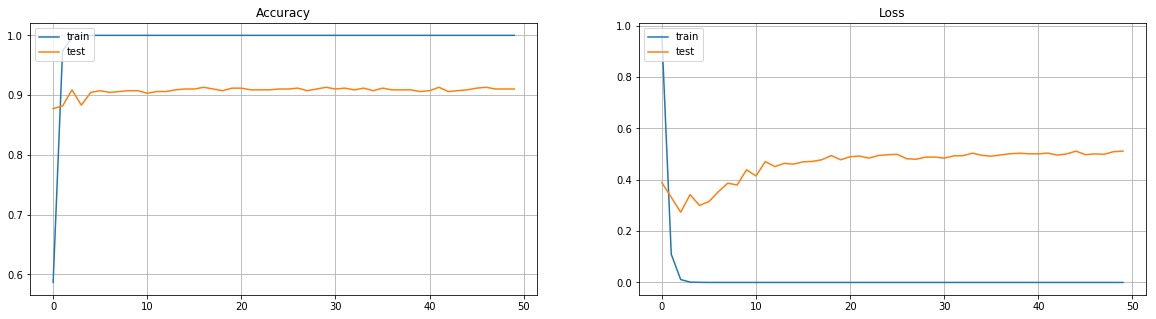

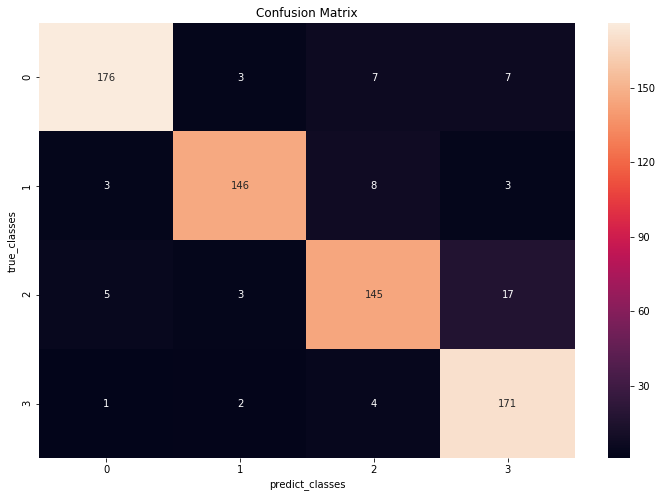

処理時間：149.09560012817383[s]


,text,true_label,pre_label,prediction
0,DeNA春田真会長、プロ野球参入の理由は「12個しかないアセットを会社で持つ重みがある」,スポーツ,ライフ,0.943717
1,「直訳かよ」MLB日本開幕戦の動画が話題に,スポーツ,映画,0.561716
2,【Sports Watch】アントニオ猪木、幻の試合映像が公開,スポーツ,映画,0.647520
3,【Sports Watch】亀田興毅が被災地に物資「子供達がちょっとでも元気になってく...,スポーツ,映画,0.974652
4,【Sports Watch】八百長調査委員に、たけし「役に立たねーじゃねーか」,スポーツ,IT,0.664930
5,【Sports Watch】内田篤人、好きな女性芸能人を前に「真っ白なんですけど」,スポーツ,ライフ,0.996748
6,【Sports Watch】国母の服装問題に、山本KID「くだらん」,スポーツ,ライフ,0.645087
7,【Sports Watch】大相撲八百長問題、4人に1人が「即刻解散をするべき」,スポーツ,映画,0.485902
8,【Sports Watch】鬼嫁・新山千春“ゴミが私の手にやってくるって考えられない”,スポーツ,ライフ,0.999888
9,アクション女優も顔負けの美女空手家＝宇佐美里香,スポーツ,映画,0.981697


In [5]:
MLP(A_index[0], B_index[0], C_index[0], D_index[0], E_index[0], F_index[0], x_size, p=0)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 4s 1ms/step - loss: 0.9502 - acc: 0.6044 - val_loss: 0.4132 - val_acc: 0.8490
Epoch 2/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.1036 - acc: 0.9718 - val_loss: 0.2751 - val_acc: 0.8960
Epoch 3/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.2759 - val_acc: 0.9003
Epoch 4/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.2740 - val_acc: 0.9103
Epoch 5/50
2806/2806 [==============================] - 3s 1ms/step - loss: 2.0974e-04 - acc: 1.0000 - val_loss: 0.2995 - val_acc: 0.9003
Epoch 6/50
2806/2806 [==============================] - 3s 1ms/step - loss: 5.0641e-05 - acc: 1.0000 - val_loss: 0.3008 - val_acc: 0.9074
Epoch 7/50
2806/2806 [==============================] - 3s 1ms/step - loss: 1.9309e-05 - acc: 1.0000 - val_loss: 0.3199 - val_acc: 0.9046
Epo

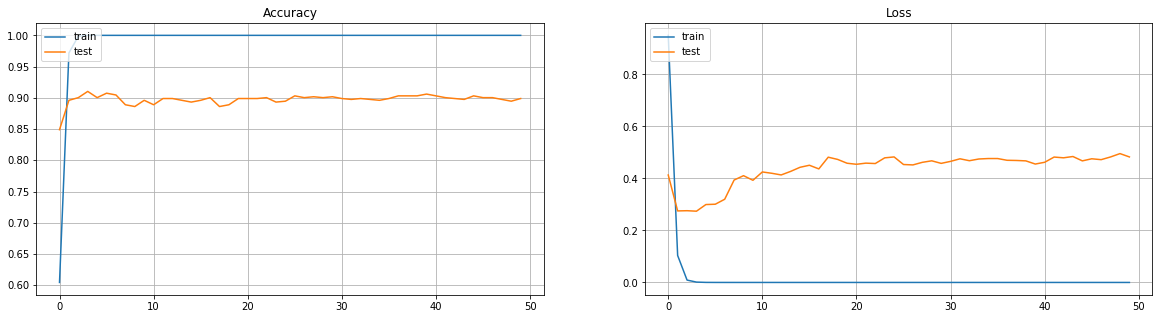

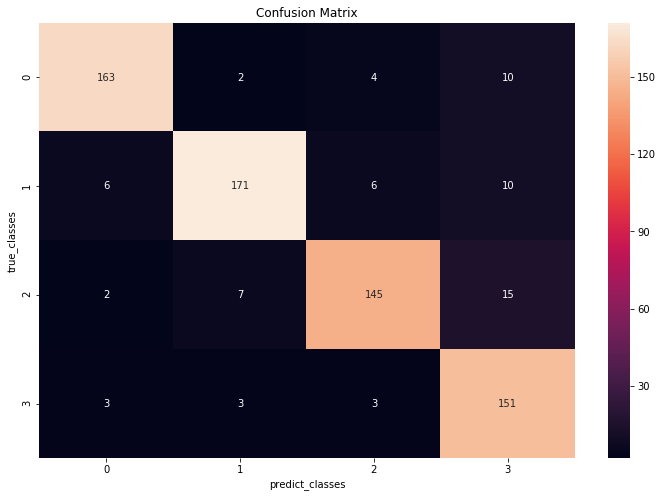

処理時間：180.7756290435791[s]


,text,true_label,pre_label,prediction
0,NHKのサッカー中継で放送事故!?ネットユーザー「これはアウト」,スポーツ,IT,0.994718
1,“日本の心臓”遠藤保仁の凄すぎるプレー、日本を救った1本のパスとは？,スポーツ,IT,0.521704
2,“異常な時代”の終焉、レーザーレーサーの今とは,スポーツ,映画,0.406009
3,【Sports Watch】上田桃子「この度、結婚致します」,スポーツ,ライフ,0.552732
4,【Sports Watch】紗栄子に急接近する「新たな男」の存在とは？,スポーツ,ライフ,0.941136
5,【Sports Watch】高田延彦の衝撃プロポーズ 「テレビを観てて好きになった」,スポーツ,ライフ,0.716962
6,コート上とは別人? “天然過ぎる”女子バレー若手コンビ＝江畑＆岩坂,スポーツ,ライフ,0.865403
7,元巨人・槙原が完全試合を達成した理由を告白、マツコは「むしろ、聞きたくなかった」,スポーツ,ライフ,0.892452
8,北京五輪断念〜どん底から復活を遂げた22歳・絹川愛,スポーツ,映画,0.542044
9,吉田沙保里が澤に相談 「好きな人ができてさぁ」,スポーツ,ライフ,0.991763


In [6]:
MLP(A_index[1], B_index[1], C_index[1], D_index[1], E_index[1], F_index[1], x_size, p=1)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 5s 2ms/step - loss: 0.9404 - acc: 0.6055 - val_loss: 0.4684 - val_acc: 0.8305
Epoch 2/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.0979 - acc: 0.9754 - val_loss: 0.3663 - val_acc: 0.8746
Epoch 3/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.0089 - acc: 0.9982 - val_loss: 0.3956 - val_acc: 0.8775
Epoch 4/50
2806/2806 [==============================] - 4s 1ms/step - loss: 8.0614e-04 - acc: 1.0000 - val_loss: 0.3980 - val_acc: 0.8732
Epoch 5/50
2806/2806 [==============================] - 4s 1ms/step - loss: 2.4382e-04 - acc: 1.0000 - val_loss: 0.4246 - val_acc: 0.8789
Epoch 6/50
2806/2806 [==============================] - 3s 1ms/step - loss: 5.4842e-05 - acc: 1.0000 - val_loss: 0.4365 - val_acc: 0.8761
Epoch 7/50
2806/2806 [==============================] - 3s 1ms/step - loss: 1.4677e-05 - acc: 1.0000 - val_loss: 0.4596 - val_acc: 0.8761

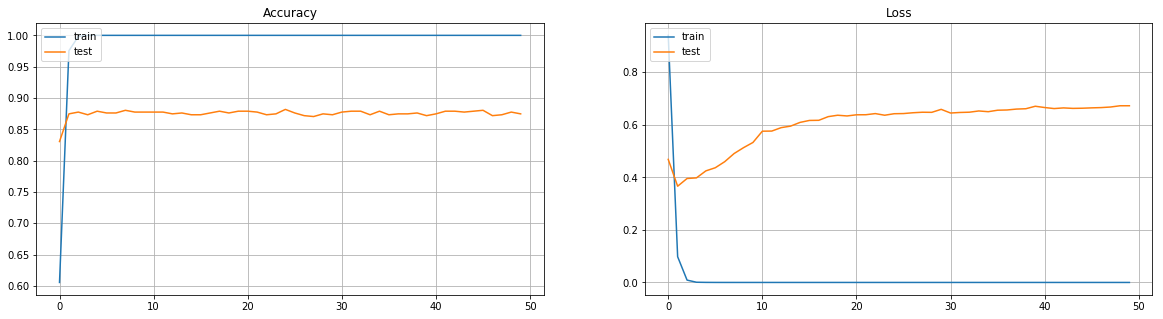

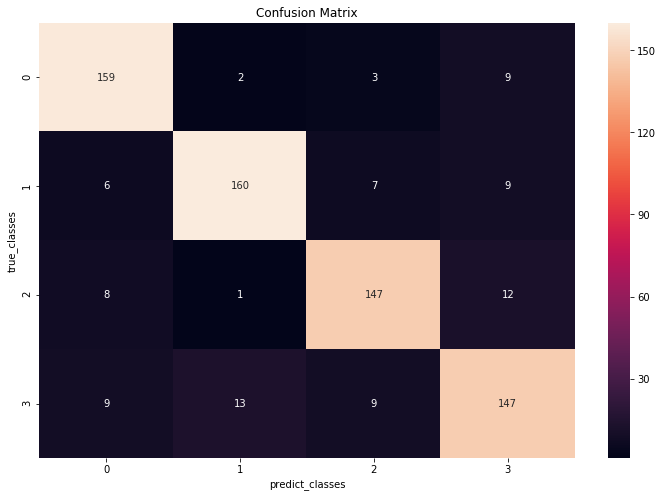

処理時間：166.24459719657898[s]


,text,true_label,pre_label,prediction
0,TBS人気企画「ガチ相撲」、ヒョードルも参戦した第3回大会優勝者は意外な男に・・・,スポーツ,ライフ,0.999252
1,「うどん県」ロゴ採用に「罰ゲームか」の声,スポーツ,IT,0.982864
2,「自分で言っちゃった」川澄が明かす、遅咲きのサッカー人生,スポーツ,ライフ,0.685207
3,「酷すぎる」選抜高校野球に誤審続出,スポーツ,ライフ,0.728316
4,【Sports Watch】人気ジョッキー・三浦に起こった“ショッキングな出来事”,スポーツ,ライフ,0.997932
5,【Sports Watch】女性が観戦したいスポーツ、1位はフィギュアスケートに——,スポーツ,ライフ,0.587310
6,【Sports Watch】子供がなりたい職業とは？,スポーツ,IT,0.723297
7,プロレスラー・小橋建太が骨折しても病院に行かないワケ,スポーツ,ライフ,0.944185
8,北島に勝った立石、隣のコースは「あんま見ないようにしていました」,スポーツ,映画,0.830614
9,売上は月1900万円!? 元女子レスラーが経営したキャバクラの全貌とは？,スポーツ,ライフ,0.984306


In [7]:
MLP(A_index[2], B_index[2], C_index[2], D_index[2], E_index[2], F_index[2], x_size, p=2)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 4s 2ms/step - loss: 0.9464 - acc: 0.5978 - val_loss: 0.4309 - val_acc: 0.8531
Epoch 2/50
2807/2807 [==============================] - 3s 1ms/step - loss: 0.0970 - acc: 0.9761 - val_loss: 0.4059 - val_acc: 0.8588
Epoch 3/50
2807/2807 [==============================] - 3s 1ms/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.4248 - val_acc: 0.8716
Epoch 4/50
2807/2807 [==============================] - 3s 1ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4014 - val_acc: 0.8773
Epoch 5/50
2807/2807 [==============================] - 3s 1ms/step - loss: 1.7105e-04 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.8830
Epoch 6/50
2807/2807 [==============================] - 3s 1ms/step - loss: 6.2645e-05 - acc: 1.0000 - val_loss: 0.4511 - val_acc: 0.8859
Epoch 7/50
2807/2807 [==============================] - 3s 1ms/step - loss: 1.4129e-05 - acc: 1.0000 - val_loss: 0.4752 - val_acc: 0.8845
Epo

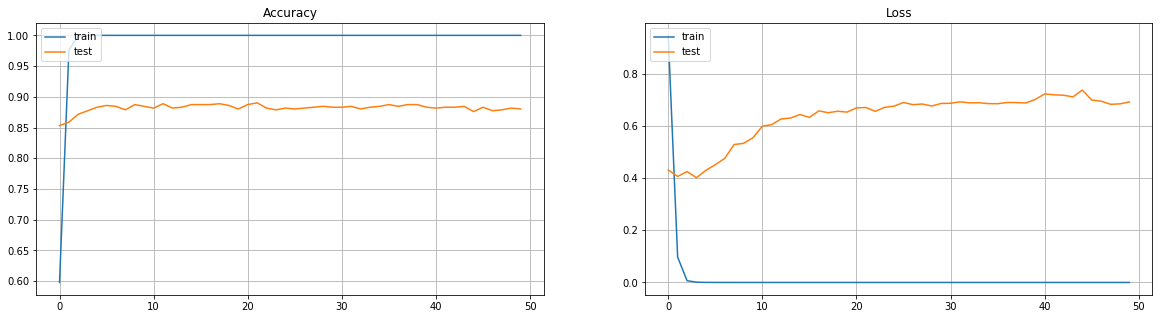

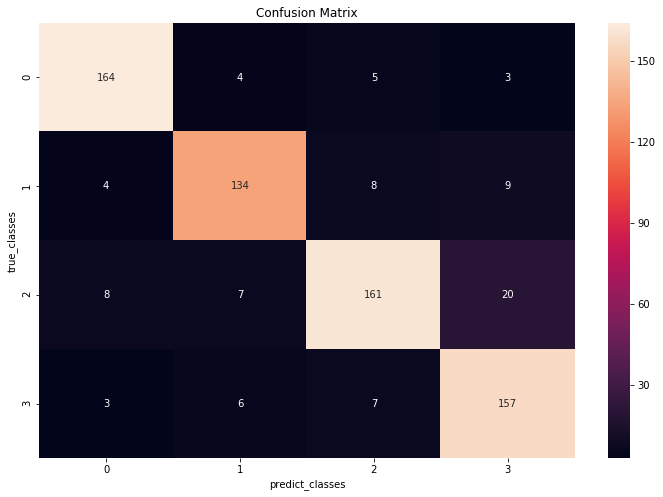

処理時間：157.37021493911743[s]


,text,true_label,pre_label,prediction
0,「チャンスはある」 ベッカムがロンドン五輪で代表復帰か,スポーツ,IT,0.989043
1,「跳躍系の選手に美形が多い」徳光アナ一押しの女子アスリートとは,スポーツ,ライフ,0.741639
2,【Sports Watch】ロンドン五輪まで一年、潮田“オリンピックの悔しさは、オリン...,スポーツ,IT,0.725886
3,あどけない笑顔の23歳・迫田、強烈バックアタックは全日本の新たな武器に,スポーツ,映画,0.983148
4,スター性抜群、次代を担う“超美少女スケーター”今井遥に注目,スポーツ,映画,0.582698
5,ディーン元気、やり投げの秘密 「あり得ないところまでいく」,スポーツ,IT,0.941093
6,ユーロでも大胆不敵、″悪童″バロテッリとは何者なのか,スポーツ,映画,0.725168
7,多田野、山なりの超スローボールで話題も風当たりは今も厳しく・・・,スポーツ,IT,0.752919
8,宇佐美嫁の日記が「ラピュタ」すぎると話題に,スポーツ,ライフ,0.905426
9,敵サポーター襲来、鳥取市内が異常事態に？,スポーツ,映画,0.844095


In [8]:
MLP(A_index[3], B_index[3], C_index[3], D_index[3], E_index[3], F_index[3], x_size, p=3)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 5s 2ms/step - loss: 0.9677 - acc: 0.6014 - val_loss: 0.3653 - val_acc: 0.8787
Epoch 2/50
2807/2807 [==============================] - 3s 1ms/step - loss: 0.1103 - acc: 0.9751 - val_loss: 0.2718 - val_acc: 0.9030
Epoch 3/50
2807/2807 [==============================] - 4s 1ms/step - loss: 0.0123 - acc: 0.9971 - val_loss: 0.2880 - val_acc: 0.9001
Epoch 4/50
2807/2807 [==============================] - 3s 972us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2955 - val_acc: 0.9073
Epoch 5/50
2807/2807 [==============================] - 3s 1ms/step - loss: 2.2034e-04 - acc: 1.0000 - val_loss: 0.3139 - val_acc: 0.9073
Epoch 6/50
2807/2807 [==============================] - 3s 979us/step - loss: 6.1401e-05 - acc: 1.0000 - val_loss: 0.3182 - val_acc: 0.9044
Epoch 7/50
2807/2807 [==============================] - 3s 989us/step - loss: 1.5480e-05 - acc: 1.0000 - val_loss: 0.3438 - val_acc: 0.90

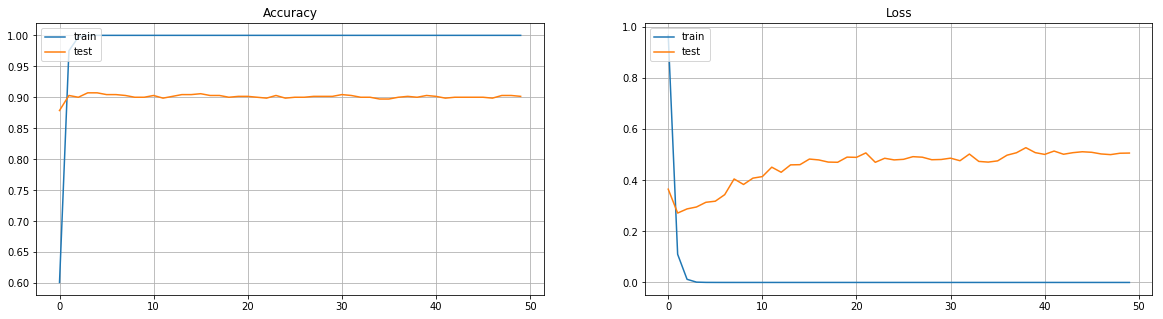

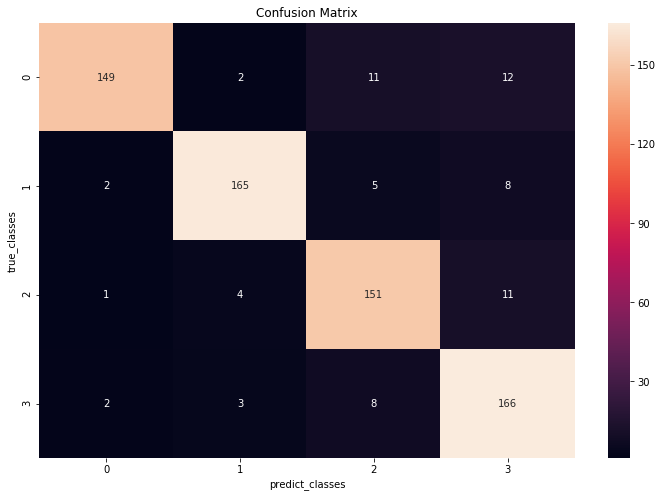

処理時間：216.75940012931824[s]


,text,true_label,pre_label,prediction
0,【Sports Watch】ROOKIES俳優も不信感、進歩なき大晦日格闘技イベント,スポーツ,映画,0.611691
1,【Sports Watch】亀田興に、絢香似の彼女がラブレター “ホンマ自慢の彼氏です”,スポーツ,ライフ,0.988256
2,【Sports Watch】人気女子ゴルファー、苦難の時代を語る,スポーツ,ライフ,0.837347
3,【Sports Watch】大人気ラウンドガールがCM出演、セクシーボディを披露!!,スポーツ,映画,0.999997
4,【Sports Watch】最強ミランのサポート施設「ミランラボ」とは？,スポーツ,IT,0.807644
5,【Sports Watch】東原亜希、夫の金メダル「見たことない」,スポーツ,ライフ,0.922908
6,まだまだある“キングカズ”の知られざるエピソード,スポーツ,ライフ,0.996929
7,インテル長友、チーム内で”いじられ役”ファン「いじめではないのか？」,スポーツ,映画,0.508663
8,エジプトのサッカー場暴動に「世界が日本を見習うべき」,スポーツ,映画,0.999428
9,オリックス・バファローズ、戦力外通告選手に無情な対応,スポーツ,IT,0.960475


In [9]:
MLP(A_index[4], B_index[4], C_index[4], D_index[4], E_index[4], F_index[4], x_size, p=4)